In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as pyplot

from math import sqrt
from math import inf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

import tensorflow as tf

Using TensorFlow backend.


In [10]:
dataset = pd.read_csv("../data/cleaned_data/dataset_3.csv", index_col=0).dropna()
# dataset.sort_values(by="date", inplace=True)

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def aggregate_data(dataset):
    total_pop = sum(dataset["county_population"].unique())
    dataset["proportion"] = dataset["county_population"] / total_pop
    
    weighted_avg = pd.DataFrame()
    for date, date_data in dataset.groupby("date"):
        weighted_avg = weighted_avg.append(
            pd.DataFrame(date_data.iloc[:, 3:-3]
                .multiply(date_data["proportion"], axis=0)
                .sum(axis=0)).T, ignore_index=True)
        
    sum_data = dataset.groupby("date").agg("sum")[["cases", "deaths"]]
    data = pd.concat([sum_data, weighted_avg], axis=1)
    n_feats = len(data.columns)
    
    return data, n_feats

In [5]:
def split_data(values, days_predicted, train_prop=.8):
#     reframed = series_to_supervised(scaled_data, n_in=days_prior, n_out=days_predicted)
    
#     drop = [col for col in reframed.columns if '-' not in col and 'var1' not in col and 'var2' not in col]
#     reframed.drop(drop, axis=1, inplace=True)
#     values = reframed.values
    
    train_size = int(.8 * values.shape[0])
    train, test = values[:train_size, :], values[train_size:, :]
    X_train, y_train = train[:, :-2*days_predicted], train[:, -2*days_predicted:]
    X_test, y_test = test[:, :-2*days_predicted], test[:, -2*days_predicted:]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_train, y_train, X_test, y_test

In [6]:
def build_model(X_train, y_train, X_test, y_test, n_batch=1):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(128))
    model.add(Dense(y_train.shape[1])) # this might need to be changed
    model.compile(Adam(learning_rate=.00001), loss="mae")
    
    history = model.fit(X_train, y_train, epochs=100, 
                    batch_size=n_batch, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    return model

In [7]:
def model_configs():
    n_in = [21, 14, 7, 5, 3]
    n_out = [1,2,3,7]
    n_batch = [1, 5, 10]
    
    configs = []
    for i in n_in:
        for j in n_out:
            for k in n_batch:
                        cfg = [i, j, k]
                        configs.append(cfg)
    total_configs = len(configs)
    print(total_configs)
    return configs
    

In [8]:
def evaluate(model, X_test, y_test, n_feats, scaler):
    predictions = y_test.shape[1]
    yhat = model.predict(X_test)
    X_test_reshape = X_test.reshape(X_test.shape[0], X_test.shape[2])
    inv_yhat = np.concatenate((X_test_reshape[:, :], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-predictions:]
    y_test_reshaped = y_test.reshape((len(y_test), predictions))
    inv_y = np.concatenate((X_test_reshape[:, :], y_test_reshaped), axis=1)
    full = scaler.inverse_transform(inv_y)
    inv_y = full[:,-predictions:]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    return inv_yhat, inv_y, rmse

In [16]:
test = dataset
agg_d, nf = aggregate_data(test)

models = []
configs = model_configs()
configs = [configs[0], configs[15], configs[33]]


60


Train on 67 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3130 - val_loss: 0.8526
Epoch 2/100
 - 0s - loss: 0.2589 - val_loss: 0.7694
Epoch 3/100
 - 0s - loss: 0.2092 - val_loss: 0.6923
Epoch 4/100
 - 0s - loss: 0.1860 - val_loss: 0.6281
Epoch 5/100
 - 0s - loss: 0.1629 - val_loss: 0.5712
Epoch 6/100
 - 0s - loss: 0.1377 - val_loss: 0.4897
Epoch 7/100
 - 0s - loss: 0.1163 - val_loss: 0.4186
Epoch 8/100
 - 0s - loss: 0.1011 - val_loss: 0.3464
Epoch 9/100
 - 0s - loss: 0.0841 - val_loss: 0.2770
Epoch 10/100
 - 0s - loss: 0.0718 - val_loss: 0.2102
Epoch 11/100
 - 0s - loss: 0.0576 - val_loss: 0.1412
Epoch 12/100
 - 0s - loss: 0.0479 - val_loss: 0.0885
Epoch 13/100
 - 0s - loss: 0.0384 - val_loss: 0.0376
Epoch 14/100
 - 0s - loss: 0.0316 - val_loss: 0.0227
Epoch 15/100
 - 0s - loss: 0.0299 - val_loss: 0.0245
Epoch 16/100
 - 0s - loss: 0.0261 - val_loss: 0.0277
Epoch 17/100
 - 0s - loss: 0.0253 - val_loss: 0.0339
Epoch 18/100
 - 0s - loss: 0.0222 - val_loss: 0.0380
Epoch 19/10

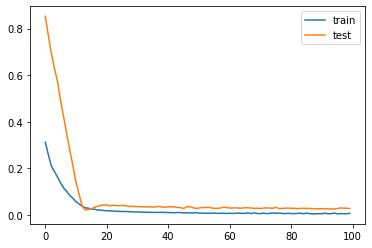

26230.038067110097
Train on 67 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3219 - val_loss: 0.9390
Epoch 2/100
 - 0s - loss: 0.2855 - val_loss: 0.8729
Epoch 3/100
 - 0s - loss: 0.2623 - val_loss: 0.8170
Epoch 4/100
 - 0s - loss: 0.2375 - val_loss: 0.7610
Epoch 5/100
 - 0s - loss: 0.2129 - val_loss: 0.7036
Epoch 6/100
 - 0s - loss: 0.1896 - val_loss: 0.6450
Epoch 7/100
 - 0s - loss: 0.1650 - val_loss: 0.5714
Epoch 8/100
 - 0s - loss: 0.1445 - val_loss: 0.5055
Epoch 9/100
 - 0s - loss: 0.1209 - val_loss: 0.4188
Epoch 10/100
 - 0s - loss: 0.0997 - val_loss: 0.3439
Epoch 11/100
 - 0s - loss: 0.0796 - val_loss: 0.2565
Epoch 12/100
 - 0s - loss: 0.0598 - val_loss: 0.1641
Epoch 13/100
 - 0s - loss: 0.0458 - val_loss: 0.0890
Epoch 14/100
 - 0s - loss: 0.0369 - val_loss: 0.0397
Epoch 15/100
 - 0s - loss: 0.0329 - val_loss: 0.0276
Epoch 16/100
 - 0s - loss: 0.0286 - val_loss: 0.0264
Epoch 17/100
 - 0s - loss: 0.0259 - val_loss: 0.0283
Epoch 18/100
 - 0s - loss: 0.0236 - val_loss:

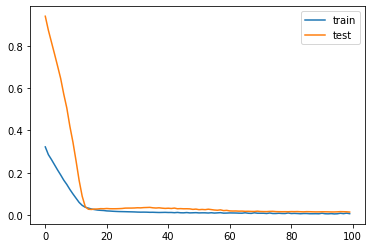

18835.764541822162
Train on 67 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3291 - val_loss: 0.7903
Epoch 2/100
 - 0s - loss: 0.2650 - val_loss: 0.6814
Epoch 3/100
 - 0s - loss: 0.2385 - val_loss: 0.6021
Epoch 4/100
 - 0s - loss: 0.2066 - val_loss: 0.5235
Epoch 5/100
 - 0s - loss: 0.1704 - val_loss: 0.4352
Epoch 6/100
 - 0s - loss: 0.1375 - val_loss: 0.3500
Epoch 7/100
 - 0s - loss: 0.1033 - val_loss: 0.2511
Epoch 8/100
 - 0s - loss: 0.0783 - val_loss: 0.1615
Epoch 9/100
 - 0s - loss: 0.0531 - val_loss: 0.0549
Epoch 10/100
 - 0s - loss: 0.0384 - val_loss: 0.0300
Epoch 11/100
 - 0s - loss: 0.0291 - val_loss: 0.0523
Epoch 12/100
 - 0s - loss: 0.0267 - val_loss: 0.0609
Epoch 13/100
 - 0s - loss: 0.0238 - val_loss: 0.0621
Epoch 14/100
 - 0s - loss: 0.0229 - val_loss: 0.0614
Epoch 15/100
 - 0s - loss: 0.0207 - val_loss: 0.0612
Epoch 16/100
 - 0s - loss: 0.0202 - val_loss: 0.0583
Epoch 17/100
 - 0s - loss: 0.0196 - val_loss: 0.0601
Epoch 18/100
 - 0s - loss: 0.0191 - val_loss:

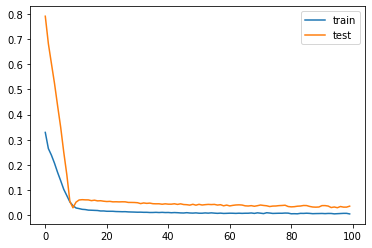

20365.910173034015
Train on 67 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3164 - val_loss: 0.8616
Epoch 2/100
 - 0s - loss: 0.2617 - val_loss: 0.7723
Epoch 3/100
 - 0s - loss: 0.2317 - val_loss: 0.7079
Epoch 4/100
 - 0s - loss: 0.2093 - val_loss: 0.6488
Epoch 5/100
 - 0s - loss: 0.1855 - val_loss: 0.5863
Epoch 6/100
 - 0s - loss: 0.1619 - val_loss: 0.5180
Epoch 7/100
 - 0s - loss: 0.1384 - val_loss: 0.4408
Epoch 8/100
 - 0s - loss: 0.1156 - val_loss: 0.3581
Epoch 9/100
 - 0s - loss: 0.0939 - val_loss: 0.2718
Epoch 10/100
 - 0s - loss: 0.0753 - val_loss: 0.1902
Epoch 11/100
 - 0s - loss: 0.0548 - val_loss: 0.0923
Epoch 12/100
 - 0s - loss: 0.0398 - val_loss: 0.0324
Epoch 13/100
 - 0s - loss: 0.0339 - val_loss: 0.0315
Epoch 14/100
 - 0s - loss: 0.0299 - val_loss: 0.0366
Epoch 15/100
 - 0s - loss: 0.0275 - val_loss: 0.0386
Epoch 16/100
 - 0s - loss: 0.0250 - val_loss: 0.0405
Epoch 17/100
 - 0s - loss: 0.0237 - val_loss: 0.0398
Epoch 18/100
 - 0s - loss: 0.0223 - val_loss:

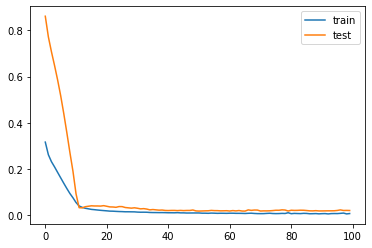

17030.907131844033


In [76]:
# Model 1: Predicting 1 day ahead


config=configs[0]

sliding_window = series_to_supervised(agg_d, config[0], config[1])
drop = [col for col in sliding_window.columns if '-' not in col and 'var1' not in col and 'var2' not in col]
sliding_window.drop(drop, axis=1, inplace=True)
values = sliding_window.values
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_d = scaler.fit_transform(values)
X_train, y_train, X_test, y_test = split_data(scaled_d, config[1])
model = build_model(X_train, y_train, X_test, y_test, config[2])
models.append(model)
inv_yhat, inv_y, rmse = evaluate(model, X_test, y_test, nf, scaler)
print(rmse)

In [77]:
model.save("1daymodel")

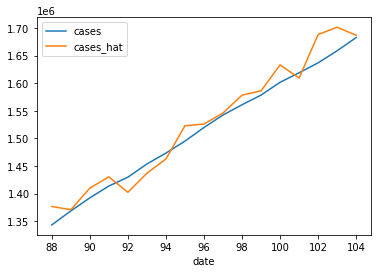

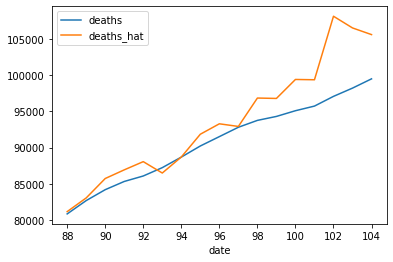

In [78]:
inv_y_df = pd.DataFrame(inv_y)
inv_yhat_df = pd.DataFrame(inv_yhat)
dates = agg_d.iloc[-(len(inv_y_df)):][["cases", "deaths"]].reset_index()
results = pd.DataFrame()
results = pd.concat([dates.drop(["cases", "deaths"], axis=1), inv_y_df, inv_yhat_df], axis=1)
results.columns = ["date", "cases", "deaths", "cases_hat", "deaths_hat"]
results.plot(x="date", y=["cases", "cases_hat"])
results.plot(x="date", y=["deaths", "deaths_hat"])

Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2999 - val_loss: 0.9190
Epoch 2/100
 - 0s - loss: 0.2613 - val_loss: 0.8687
Epoch 3/100
 - 0s - loss: 0.2365 - val_loss: 0.8298
Epoch 4/100
 - 0s - loss: 0.2253 - val_loss: 0.7993
Epoch 5/100
 - 0s - loss: 0.2115 - val_loss: 0.7655
Epoch 6/100
 - 0s - loss: 0.1980 - val_loss: 0.7299
Epoch 7/100
 - 0s - loss: 0.1828 - val_loss: 0.6885
Epoch 8/100
 - 0s - loss: 0.1691 - val_loss: 0.6466
Epoch 9/100
 - 0s - loss: 0.1546 - val_loss: 0.6003
Epoch 10/100
 - 0s - loss: 0.1407 - val_loss: 0.5518
Epoch 11/100
 - 0s - loss: 0.1279 - val_loss: 0.5023
Epoch 12/100
 - 0s - loss: 0.1157 - val_loss: 0.4495
Epoch 13/100
 - 0s - loss: 0.1037 - val_loss: 0.3951
Epoch 14/100
 - 0s - loss: 0.0922 - val_loss: 0.3403
Epoch 15/100
 - 0s - loss: 0.0819 - val_loss: 0.2848
Epoch 16/100
 - 0s - loss: 0.0728 - val_loss: 0.2341
Epoch 17/100
 - 0s - loss: 0.0650 - val_loss: 0.1875
Epoch 18/100
 - 0s - loss: 0.0581 - val_loss: 0.1498
Epoch 19/10

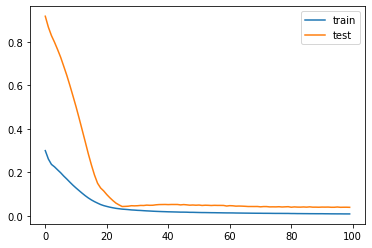

49353.80029867521
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2413 - val_loss: 0.8142
Epoch 2/100
 - 0s - loss: 0.2279 - val_loss: 0.7912
Epoch 3/100
 - 0s - loss: 0.2172 - val_loss: 0.7689
Epoch 4/100
 - 0s - loss: 0.2067 - val_loss: 0.7450
Epoch 5/100
 - 0s - loss: 0.1962 - val_loss: 0.7179
Epoch 6/100
 - 0s - loss: 0.1869 - val_loss: 0.6891
Epoch 7/100
 - 0s - loss: 0.1763 - val_loss: 0.6547
Epoch 8/100
 - 0s - loss: 0.1657 - val_loss: 0.6168
Epoch 9/100
 - 0s - loss: 0.1542 - val_loss: 0.5748
Epoch 10/100
 - 0s - loss: 0.1423 - val_loss: 0.5292
Epoch 11/100
 - 0s - loss: 0.1305 - val_loss: 0.4823
Epoch 12/100
 - 0s - loss: 0.1179 - val_loss: 0.4293
Epoch 13/100
 - 0s - loss: 0.1058 - val_loss: 0.3750
Epoch 14/100
 - 0s - loss: 0.0941 - val_loss: 0.3168
Epoch 15/100
 - 0s - loss: 0.0827 - val_loss: 0.2587
Epoch 16/100
 - 0s - loss: 0.0713 - val_loss: 0.1981
Epoch 17/100
 - 0s - loss: 0.0603 - val_loss: 0.1386
Epoch 18/100
 - 0s - loss: 0.0520 - val_loss: 

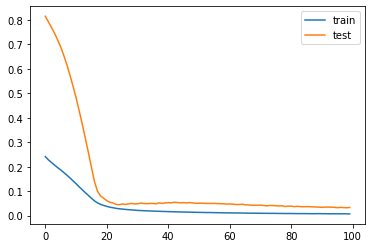

34989.15589165284
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2578 - val_loss: 0.8383
Epoch 2/100
 - 0s - loss: 0.2409 - val_loss: 0.8074
Epoch 3/100
 - 0s - loss: 0.2277 - val_loss: 0.7784
Epoch 4/100
 - 0s - loss: 0.2141 - val_loss: 0.7488
Epoch 5/100
 - 0s - loss: 0.2000 - val_loss: 0.7159
Epoch 6/100
 - 0s - loss: 0.1859 - val_loss: 0.6780
Epoch 7/100
 - 0s - loss: 0.1736 - val_loss: 0.6382
Epoch 8/100
 - 0s - loss: 0.1605 - val_loss: 0.5919
Epoch 9/100
 - 0s - loss: 0.1475 - val_loss: 0.5422
Epoch 10/100
 - 0s - loss: 0.1337 - val_loss: 0.4869
Epoch 11/100
 - 0s - loss: 0.1208 - val_loss: 0.4324
Epoch 12/100
 - 0s - loss: 0.1076 - val_loss: 0.3711
Epoch 13/100
 - 0s - loss: 0.0956 - val_loss: 0.3113
Epoch 14/100
 - 0s - loss: 0.0832 - val_loss: 0.2494
Epoch 15/100
 - 0s - loss: 0.0738 - val_loss: 0.2060
Epoch 16/100
 - 0s - loss: 0.0659 - val_loss: 0.1678
Epoch 17/100
 - 0s - loss: 0.0579 - val_loss: 0.1413
Epoch 18/100
 - 0s - loss: 0.0519 - val_loss: 

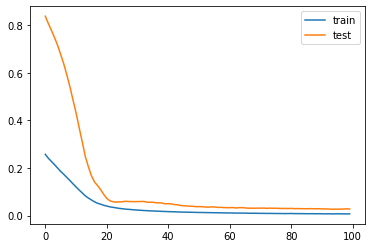

26490.609699077257
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2610 - val_loss: 0.8460
Epoch 2/100
 - 0s - loss: 0.2413 - val_loss: 0.8138
Epoch 3/100
 - 0s - loss: 0.2246 - val_loss: 0.7810
Epoch 4/100
 - 0s - loss: 0.2110 - val_loss: 0.7528
Epoch 5/100
 - 0s - loss: 0.1983 - val_loss: 0.7213
Epoch 6/100
 - 0s - loss: 0.1863 - val_loss: 0.6872
Epoch 7/100
 - 0s - loss: 0.1746 - val_loss: 0.6492
Epoch 8/100
 - 0s - loss: 0.1621 - val_loss: 0.6065
Epoch 9/100
 - 0s - loss: 0.1501 - val_loss: 0.5619
Epoch 10/100
 - 0s - loss: 0.1379 - val_loss: 0.5149
Epoch 11/100
 - 0s - loss: 0.1265 - val_loss: 0.4658
Epoch 12/100
 - 0s - loss: 0.1137 - val_loss: 0.4095
Epoch 13/100
 - 0s - loss: 0.1012 - val_loss: 0.3526
Epoch 14/100
 - 0s - loss: 0.0885 - val_loss: 0.2915
Epoch 15/100
 - 0s - loss: 0.0779 - val_loss: 0.2346
Epoch 16/100
 - 0s - loss: 0.0678 - val_loss: 0.1763
Epoch 17/100
 - 0s - loss: 0.0586 - val_loss: 0.1232
Epoch 18/100
 - 0s - loss: 0.0520 - val_loss:

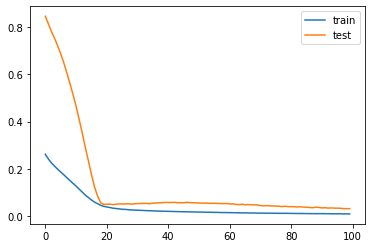

30307.08591078091
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2580 - val_loss: 0.7945
Epoch 2/100
 - 0s - loss: 0.2439 - val_loss: 0.7703
Epoch 3/100
 - 0s - loss: 0.2296 - val_loss: 0.7464
Epoch 4/100
 - 0s - loss: 0.2169 - val_loss: 0.7219
Epoch 5/100
 - 0s - loss: 0.2041 - val_loss: 0.6977
Epoch 6/100
 - 0s - loss: 0.1915 - val_loss: 0.6718
Epoch 7/100
 - 0s - loss: 0.1782 - val_loss: 0.6424
Epoch 8/100
 - 0s - loss: 0.1657 - val_loss: 0.6103
Epoch 9/100
 - 0s - loss: 0.1527 - val_loss: 0.5731
Epoch 10/100
 - 0s - loss: 0.1405 - val_loss: 0.5331
Epoch 11/100
 - 0s - loss: 0.1276 - val_loss: 0.4906
Epoch 12/100
 - 0s - loss: 0.1155 - val_loss: 0.4447
Epoch 13/100
 - 0s - loss: 0.1043 - val_loss: 0.3962
Epoch 14/100
 - 0s - loss: 0.0934 - val_loss: 0.3453
Epoch 15/100
 - 0s - loss: 0.0821 - val_loss: 0.2894
Epoch 16/100
 - 0s - loss: 0.0718 - val_loss: 0.2367
Epoch 17/100
 - 0s - loss: 0.0625 - val_loss: 0.1802
Epoch 18/100
 - 0s - loss: 0.0548 - val_loss: 

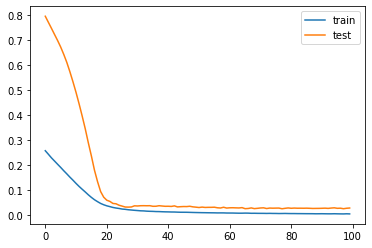

27776.706895368505
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.3027 - val_loss: 0.7759
Epoch 2/100
 - 0s - loss: 0.2650 - val_loss: 0.7165
Epoch 3/100
 - 0s - loss: 0.2338 - val_loss: 0.6661
Epoch 4/100
 - 0s - loss: 0.2109 - val_loss: 0.6250
Epoch 5/100
 - 0s - loss: 0.1938 - val_loss: 0.5861
Epoch 6/100
 - 0s - loss: 0.1775 - val_loss: 0.5461
Epoch 7/100
 - 0s - loss: 0.1629 - val_loss: 0.5061
Epoch 8/100
 - 0s - loss: 0.1474 - val_loss: 0.4622
Epoch 9/100
 - 0s - loss: 0.1327 - val_loss: 0.4180
Epoch 10/100
 - 0s - loss: 0.1175 - val_loss: 0.3665
Epoch 11/100
 - 0s - loss: 0.1028 - val_loss: 0.3187
Epoch 12/100
 - 0s - loss: 0.0913 - val_loss: 0.2548
Epoch 13/100
 - 0s - loss: 0.0794 - val_loss: 0.1952
Epoch 14/100
 - 0s - loss: 0.0682 - val_loss: 0.1335
Epoch 15/100
 - 0s - loss: 0.0586 - val_loss: 0.0991
Epoch 16/100
 - 0s - loss: 0.0516 - val_loss: 0.0825
Epoch 17/100
 - 0s - loss: 0.0456 - val_loss: 0.0631
Epoch 18/100
 - 0s - loss: 0.0404 - val_loss:

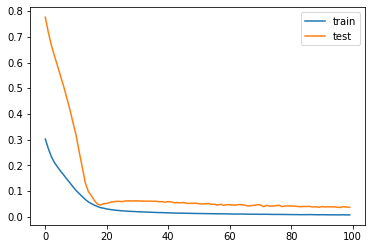

36276.552203259365
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2751 - val_loss: 0.8857
Epoch 2/100
 - 0s - loss: 0.2526 - val_loss: 0.8401
Epoch 3/100
 - 0s - loss: 0.2393 - val_loss: 0.8048
Epoch 4/100
 - 0s - loss: 0.2270 - val_loss: 0.7708
Epoch 5/100
 - 0s - loss: 0.2141 - val_loss: 0.7339
Epoch 6/100
 - 0s - loss: 0.2012 - val_loss: 0.6959
Epoch 7/100
 - 0s - loss: 0.1877 - val_loss: 0.6551
Epoch 8/100
 - 0s - loss: 0.1738 - val_loss: 0.6126
Epoch 9/100
 - 0s - loss: 0.1596 - val_loss: 0.5679
Epoch 10/100
 - 0s - loss: 0.1445 - val_loss: 0.5186
Epoch 11/100
 - 0s - loss: 0.1287 - val_loss: 0.4624
Epoch 12/100
 - 0s - loss: 0.1150 - val_loss: 0.4049
Epoch 13/100
 - 0s - loss: 0.0994 - val_loss: 0.3384
Epoch 14/100
 - 0s - loss: 0.0853 - val_loss: 0.2732
Epoch 15/100
 - 0s - loss: 0.0730 - val_loss: 0.2109
Epoch 16/100
 - 0s - loss: 0.0613 - val_loss: 0.1496
Epoch 17/100
 - 0s - loss: 0.0508 - val_loss: 0.0961
Epoch 18/100
 - 0s - loss: 0.0427 - val_loss:

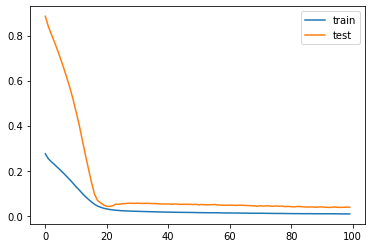

29341.035069953603
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2627 - val_loss: 0.8539
Epoch 2/100
 - 0s - loss: 0.2460 - val_loss: 0.8226
Epoch 3/100
 - 0s - loss: 0.2286 - val_loss: 0.7910
Epoch 4/100
 - 0s - loss: 0.2109 - val_loss: 0.7573
Epoch 5/100
 - 0s - loss: 0.1940 - val_loss: 0.7202
Epoch 6/100
 - 0s - loss: 0.1782 - val_loss: 0.6801
Epoch 7/100
 - 0s - loss: 0.1642 - val_loss: 0.6365
Epoch 8/100
 - 0s - loss: 0.1514 - val_loss: 0.5904
Epoch 9/100
 - 0s - loss: 0.1383 - val_loss: 0.5386
Epoch 10/100
 - 0s - loss: 0.1256 - val_loss: 0.4846
Epoch 11/100
 - 0s - loss: 0.1127 - val_loss: 0.4291
Epoch 12/100
 - 0s - loss: 0.1009 - val_loss: 0.3725
Epoch 13/100
 - 0s - loss: 0.0901 - val_loss: 0.3183
Epoch 14/100
 - 0s - loss: 0.0798 - val_loss: 0.2630
Epoch 15/100
 - 0s - loss: 0.0704 - val_loss: 0.2087
Epoch 16/100
 - 0s - loss: 0.0617 - val_loss: 0.1567
Epoch 17/100
 - 0s - loss: 0.0548 - val_loss: 0.1105
Epoch 18/100
 - 0s - loss: 0.0504 - val_loss:

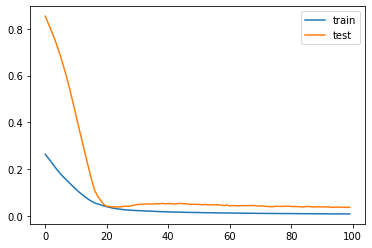

33522.36001802045
Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2829 - val_loss: 0.8607
Epoch 2/100
 - 0s - loss: 0.2583 - val_loss: 0.8198
Epoch 3/100
 - 0s - loss: 0.2346 - val_loss: 0.7798
Epoch 4/100
 - 0s - loss: 0.2182 - val_loss: 0.7485
Epoch 5/100
 - 0s - loss: 0.2055 - val_loss: 0.7192
Epoch 6/100
 - 0s - loss: 0.1912 - val_loss: 0.6839
Epoch 7/100
 - 0s - loss: 0.1787 - val_loss: 0.6482
Epoch 8/100
 - 0s - loss: 0.1666 - val_loss: 0.6081
Epoch 9/100
 - 0s - loss: 0.1551 - val_loss: 0.5689
Epoch 10/100
 - 0s - loss: 0.1430 - val_loss: 0.5204
Epoch 11/100
 - 0s - loss: 0.1317 - val_loss: 0.4769
Epoch 12/100
 - 0s - loss: 0.1196 - val_loss: 0.4237
Epoch 13/100
 - 0s - loss: 0.1078 - val_loss: 0.3735
Epoch 14/100
 - 0s - loss: 0.0962 - val_loss: 0.3193
Epoch 15/100
 - 0s - loss: 0.0849 - val_loss: 0.2638
Epoch 16/100
 - 0s - loss: 0.0742 - val_loss: 0.2081
Epoch 17/100
 - 0s - loss: 0.0640 - val_loss: 0.1598
Epoch 18/100
 - 0s - loss: 0.0551 - val_loss: 

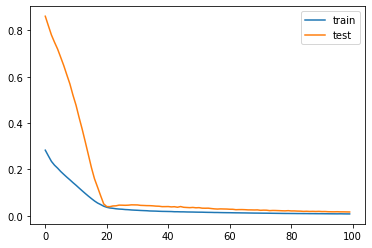

15017.209254777026


In [72]:
# Model 2: Predicting 3 days ahead
config=configs[1]
sliding_window = series_to_supervised(agg_d, config[0], config[1])
drop = [col for col in sliding_window.columns if '-' not in col and 'var1' not in col and 'var2' not in col]
sliding_window.drop(drop, axis=1, inplace=True)
values = sliding_window.values
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_d = scaler.fit_transform(values)
X_train, y_train, X_test, y_test = split_data(scaled_d, config[1])
model = build_model(X_train, y_train, X_test, y_test, config[2])
models.append(model)
inv_yhat, inv_y, rmse = evaluate(model, X_test, y_test, nf, scaler)
print(rmse)

In [73]:
model.save("3daymodel")

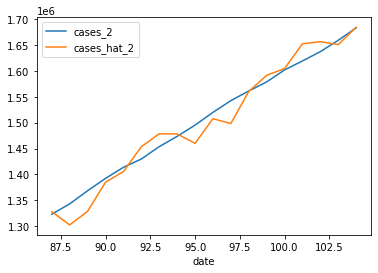

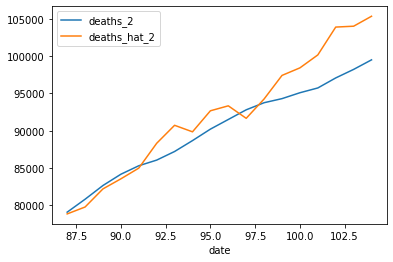

In [74]:
inv_y_df = pd.DataFrame(inv_y)
inv_yhat_df = pd.DataFrame(inv_yhat)
dates = agg_d.iloc[-(len(inv_y_df)):][["cases", "deaths"]].reset_index()
results = pd.DataFrame()
results = pd.concat([dates.drop(["cases", "deaths"], axis=1), inv_y_df, inv_yhat_df], axis=1)
results.columns = ["date", "cases", "deaths", "cases_2", "deaths_2",
                   "cases_hat", "deaths_hat", "cases_hat_2", "deaths_hat_2"]
results.plot(x="date", y=["cases_2", "cases_hat_2"])
results.plot(x="date", y=["deaths_2", "deaths_hat_2"])

Train on 73 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.2441 - val_loss: 0.8968
Epoch 2/100
 - 0s - loss: 0.2333 - val_loss: 0.8819
Epoch 3/100
 - 0s - loss: 0.2246 - val_loss: 0.8692
Epoch 4/100
 - 0s - loss: 0.2181 - val_loss: 0.8587
Epoch 5/100
 - 0s - loss: 0.2130 - val_loss: 0.8492
Epoch 6/100
 - 0s - loss: 0.2082 - val_loss: 0.8395
Epoch 7/100
 - 0s - loss: 0.2038 - val_loss: 0.8297
Epoch 8/100
 - 0s - loss: 0.1994 - val_loss: 0.8194
Epoch 9/100
 - 0s - loss: 0.1949 - val_loss: 0.8081
Epoch 10/100
 - 0s - loss: 0.1902 - val_loss: 0.7961
Epoch 11/100
 - 0s - loss: 0.1855 - val_loss: 0.7832
Epoch 12/100
 - 0s - loss: 0.1807 - val_loss: 0.7692
Epoch 13/100
 - 0s - loss: 0.1758 - val_loss: 0.7542
Epoch 14/100
 - 0s - loss: 0.1707 - val_loss: 0.7383
Epoch 15/100
 - 0s - loss: 0.1656 - val_loss: 0.7210
Epoch 16/100
 - 0s - loss: 0.1606 - val_loss: 0.7034
Epoch 17/100
 - 0s - loss: 0.1554 - val_loss: 0.6843
Epoch 18/100
 - 0s - loss: 0.1503 - val_loss: 0.6645
Epoch 19/10

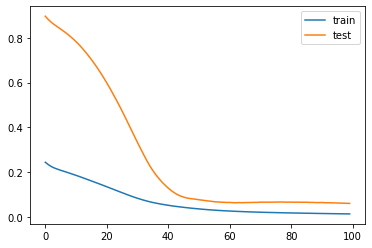

81298.26779341485
Train on 73 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.2404 - val_loss: 0.8835
Epoch 2/100
 - 0s - loss: 0.2294 - val_loss: 0.8701
Epoch 3/100
 - 0s - loss: 0.2195 - val_loss: 0.8576
Epoch 4/100
 - 0s - loss: 0.2110 - val_loss: 0.8456
Epoch 5/100
 - 0s - loss: 0.2042 - val_loss: 0.8347
Epoch 6/100
 - 0s - loss: 0.1989 - val_loss: 0.8239
Epoch 7/100
 - 0s - loss: 0.1943 - val_loss: 0.8134
Epoch 8/100
 - 0s - loss: 0.1898 - val_loss: 0.8022
Epoch 9/100
 - 0s - loss: 0.1851 - val_loss: 0.7898
Epoch 10/100
 - 0s - loss: 0.1804 - val_loss: 0.7768
Epoch 11/100
 - 0s - loss: 0.1757 - val_loss: 0.7629
Epoch 12/100
 - 0s - loss: 0.1709 - val_loss: 0.7479
Epoch 13/100
 - 0s - loss: 0.1663 - val_loss: 0.7320
Epoch 14/100
 - 0s - loss: 0.1616 - val_loss: 0.7148
Epoch 15/100
 - 0s - loss: 0.1567 - val_loss: 0.6965
Epoch 16/100
 - 0s - loss: 0.1515 - val_loss: 0.6768
Epoch 17/100
 - 0s - loss: 0.1463 - val_loss: 0.6561
Epoch 18/100
 - 0s - loss: 0.1411 - val_loss: 

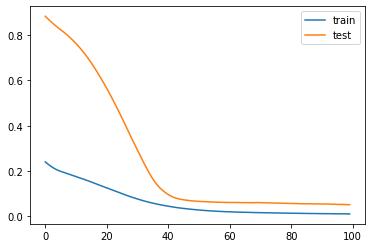

66717.12704726242


In [69]:
# Model 2: Predicting 7 days ahead

config=configs[2]

sliding_window = series_to_supervised(agg_d, config[0], config[1])
drop = [col for col in sliding_window.columns if '-' not in col and 'var1' not in col and 'var2' not in col]
sliding_window.drop(drop, axis=1, inplace=True)
values = sliding_window.values
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_d = scaler.fit_transform(values)
X_train, y_train, X_test, y_test = split_data(scaled_d, config[1])
model = build_model(X_train, y_train, X_test, y_test, config[2])
models.append(model)
inv_yhat, inv_y, rmse = evaluate(model, X_test, y_test, nf, scaler)
print(rmse)

In [70]:
model.save("7daymodel")

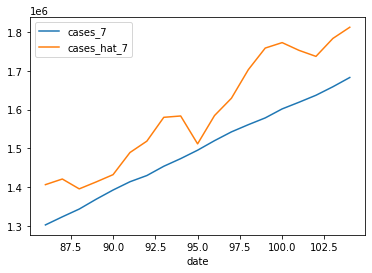

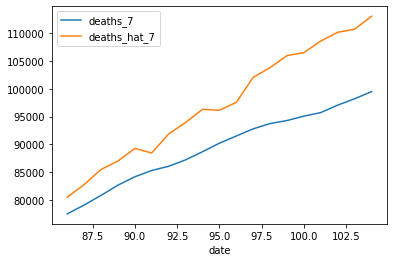

In [71]:
inv_y_df = pd.DataFrame(inv_y)
inv_yhat_df = pd.DataFrame(inv_yhat)
dates = agg_d.iloc[-(len(inv_y_df)):][["cases", "deaths"]].reset_index()
results = pd.DataFrame()
results = pd.concat([dates.drop(["cases", "deaths"], axis=1), inv_y_df, inv_yhat_df], axis=1)
results.columns = ["date", "cases", "deaths", "cases_2", "deaths_2","cases_3", 
                   "deaths_3", "cases_4", "deaths_4","cases_5", "deaths_5",
                   "cases_6", "deaths_6","cases_7", "deaths_7",
                   "cases_hat", "deaths_hat", "cases_hat_2", "deaths_hat_2",
                  "cases_hat_3", "deaths_hat_3","cases_hat_4", "deaths_hat_4",
                  "cases_hat_5", "deaths_hat_5","cases_hat_6", "deaths_hat_6",
                  "cases_hat_7", "deaths_hat_7"]
results.plot(x="date", y=["cases_7", "cases_hat_7"])
results.plot(x="date", y=["deaths_7", "deaths_hat_7"])